In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore, fdr, one_sample_permutation
from nltools.file_reader import onsets_to_dm
from nltools.plotting import component_viewer
from sklearn.metrics import pairwise_distances
from copy import deepcopy
import networkx as nx
from nilearn import plotting, image
from bids import BIDSLayout, BIDSValidator
import nibabel as nb

D:\anaconda\anaconda\envs\mne\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [6]:
data_dir = 'D:/wangsiyu/Data/Visual_search_task/BIDS/Nifti'
layout = BIDSLayout(data_dir, derivatives=True)

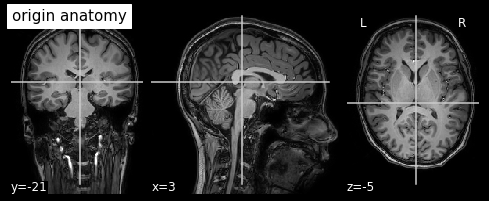

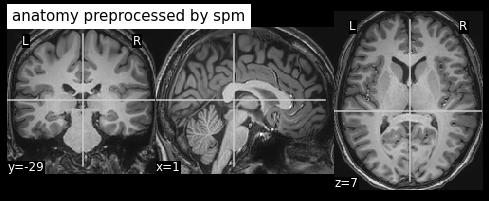

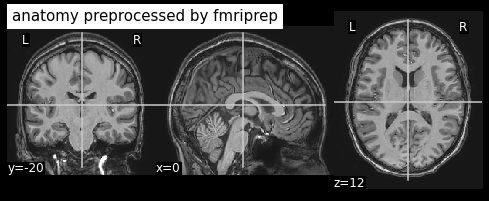

In [21]:
sub01_anat_origin = layout.get(subject='01', suffix='T1w', extension='nii')[0].path
sub01_anat_preproc_nipype = 'D:/wangsiyu/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-01/wsub-01_ses-test_anat_sT1W.nii'
sub01_anat_preproc_fmriprep = layout.get(subject='01', scope='derivatives', suffix='T1w', extension='nii.gz')[1].path

plotting.plot_anat(sub01_anat_origin, title='origin anatomy', dim=-1)
plotting.plot_anat(sub01_anat_preproc_nipype, title='anatomy preprocessed by spm', dim=-1)
plotting.plot_anat(sub01_anat_preproc_fmriprep, title='anatomy preprocessed by fmriprep', dim=-1)


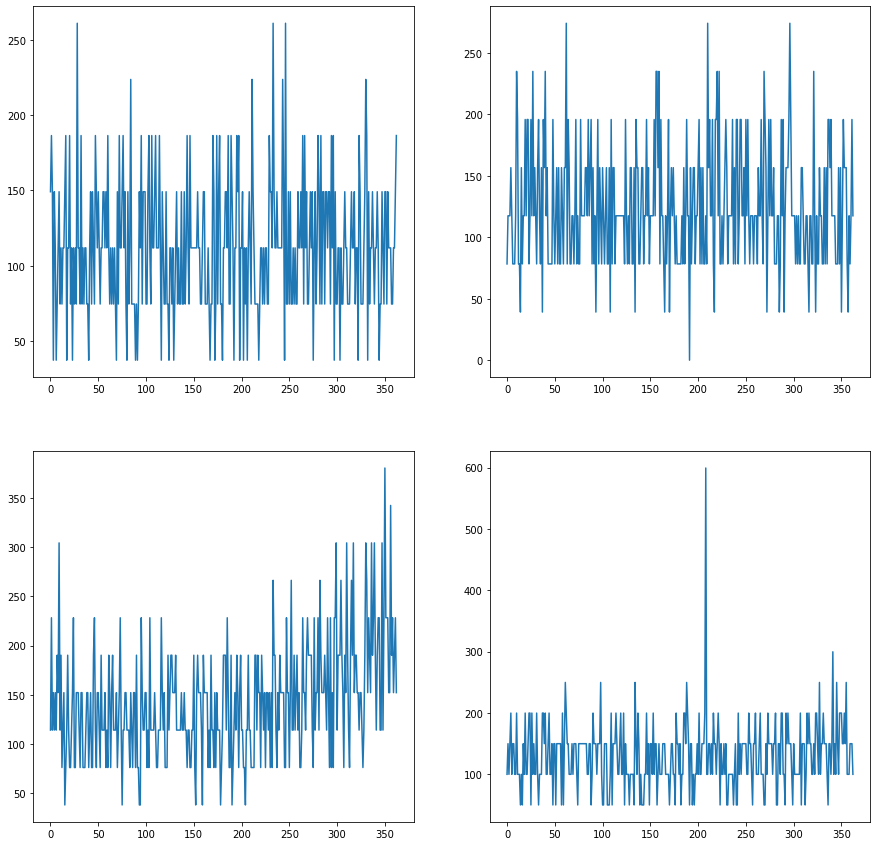

In [28]:
sub01_func_session1_origin = layout.get(subject='01', suffix='bold', task='visualsearch', extension='nii')[0].path
sub01_func_session2_origin = layout.get(subject='01', suffix='bold', task='visualsearch', extension='nii')[1].path
sub01_func_session3_origin = layout.get(subject='01', suffix='bold', task='visualsearch', extension='nii')[2].path
sub01_func_session4_origin = layout.get(subject='01', suffix='bold', task='visualsearch', extension='nii')[3].path
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.plot(nb.load(sub01_func_session1_origin).get_fdata()[-9, -91, -13, :])
plt.subplot(222)
plt.plot(nb.load(sub01_func_session2_origin).get_fdata()[-9, -91, -13, :])
plt.subplot(223)
plt.plot(nb.load(sub01_func_session3_origin).get_fdata()[-9, -91, -13, :])
plt.subplot(224)
plt.plot(nb.load(sub01_func_session4_origin).get_fdata()[-9, -91, -13, :])

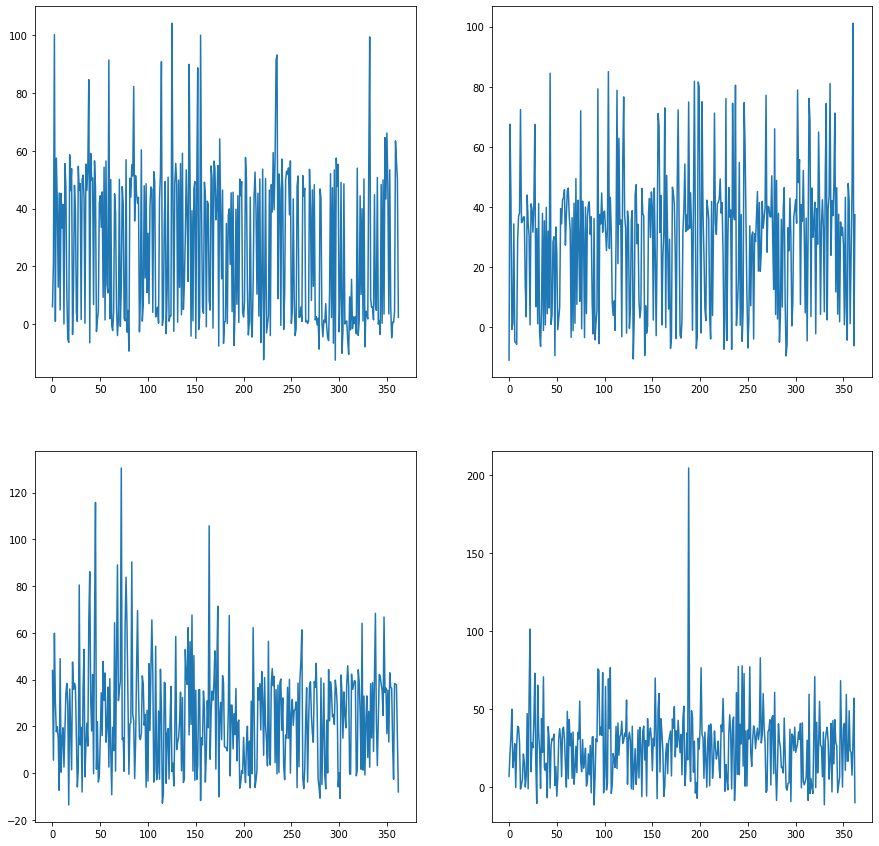

In [36]:
sub01_func_session1_cor = layout.get(subject='01', suffix='bold', scope='derivatives', task='visualsearch', extension='nii.gz')[0].path
sub01_func_session2_cor = layout.get(subject='01', suffix='bold', scope='derivatives', task='visualsearch', extension='nii.gz')[1].path
sub01_func_session3_cor = layout.get(subject='01', suffix='bold', scope='derivatives', task='visualsearch', extension='nii.gz')[2].path
sub01_func_session4_cor = layout.get(subject='01', suffix='bold', scope='derivatives', task='visualsearch', extension='nii.gz')[3].path
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.plot(nb.load(sub01_func_session4_cor).get_fdata()[-9, -91, -13, :])
plt.subplot(222)
plt.plot(nb.load(sub01_func_session2_cor).get_fdata()[-9, -91, -13, :])
plt.subplot(223)
plt.plot(nb.load(sub01_func_session3_cor).get_fdata()[-9, -91, -13, :])
plt.subplot(224)
plt.plot(nb.load(sub01_func_session1_cor).get_fdata()[-9, -91, -13, :])

虽然有相似的波动特征，但激活尺度明显不同

In [33]:
signal_list = [nb.load(sub01_func_session1_origin).get_fdata()[-9, -91, -13, :],
                nb.load(sub01_func_session2_origin).get_fdata()[-9, -91, -13, :],
                nb.load(sub01_func_session3_origin).get_fdata()[-9, -91, -13, :], 
                nb.load(sub01_func_session4_origin).get_fdata()[-9, -91, -13, :]]

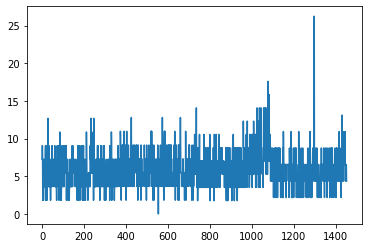

In [34]:
plt.plot(np.concatenate(signal_list, axis=0))

将4个图像拼接起来

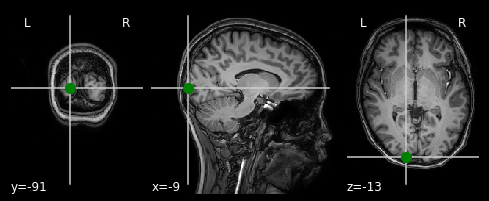

In [31]:
display = plotting.plot_anat(sub01_anat_origin, cut_coords=(-9, -91, -13), dim=-1)
display.add_markers(marker_coords=[(-9, -91, -13)], marker_color='g', marker_size=100)
